<a href="https://colab.research.google.com/github/maclandrol/cours-ia-med/blob/master/04_Classification_Texte_Medical_Francais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Classification de Texte Médical Français

**Enseignant:** Emmanuel Noutahi, PhD

---

**Objectif:** Apprendre à classifier des textes médicaux en français en utilisant des approches de prompting et d'apprentissage automatique.

**Dataset:** FrenchMedMCQA - Questions à choix multiples de pharmacie

**Approches:**
- Prompting avec ChatGPT
- Classification automatique avec CamemBERT

## Installation et Configuration

In [26]:
!pip install "datasets<4.0.0" transformers torch pandas scikit-learn matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositif: {device}")

Dispositif: cuda


## 1. Accès aux Données

In [27]:
# Chargement du dataset FrenchMedMCQA
dataset = load_dataset("qanastek/frenchmedmcqa")
print(f"Dataset chargé: {len(dataset['train'])} exemples")

Dataset chargé: 2171 exemples


## 2. Transformation en DataFrame

In [28]:
# Conversion en DataFrame
df = pd.DataFrame(dataset['train'])
print(f"DataFrame: {df.shape}")
print(f"Colonnes: {list(df.columns)}")

DataFrame: (2171, 9)
Colonnes: ['id', 'question', 'answer_a', 'answer_b', 'answer_c', 'answer_d', 'answer_e', 'correct_answers', 'number_correct_answers']


## 3. Analyse des Données

In [29]:
# Statistiques de base
print(f"Nombre de questions: {len(df)}")
print(f"Longueur moyenne des questions: {df['question'].str.len().mean():.0f} caractères")

# Distribution des réponses correctes
answer_counts = df['number_correct_answers'].value_counts().sort_index()
print("\\nNombre de bonnes réponses par question:")
for nb, count in answer_counts.items():
    print(f"  {nb} réponse(s): {count} questions")

Nombre de questions: 2171
Longueur moyenne des questions: 100 caractères
\nNombre de bonnes réponses par question:
  0 réponse(s): 595 questions
  1 réponse(s): 528 questions
  2 réponse(s): 718 questions
  3 réponse(s): 296 questions
  4 réponse(s): 34 questions


In [30]:
# Exemple de question
exemple = df.iloc[0]
print("Exemple de question:")
print(f"Q: {exemple['question']}")
print(f"A: {exemple['answer_a']}")
print(f"B: {exemple['answer_b']}")
print(f"C: {exemple['answer_c']}")
print(f"D: {exemple['answer_d']}")
print(f"E: {exemple['answer_e']}")
print(f"Réponses correctes: {exemple['correct_answers']}")

Exemple de question:
Q: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha
A: Sont formées de noyaux d'hélium
B: Sont peu pénétrantes
C: Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l'air
D: Sont arrêtées par une feuille de papier
E: Sont peu ionisantes
Réponses correctes: [4]


## 4. Prompting avec ChatGPT

### Le Rôle du Prompting

Le prompting consiste à formuler des instructions claires pour guider un modèle de langue vers la réponse souhaitée. Pour les questions médicales, un bon prompt doit:
- Définir le rôle d'expert médical
- Préciser le format de réponse attendu
- Fournir le contexte nécessaire

### Prompt Simple

In [31]:
# Génération d'un prompt simple
def generer_prompt_simple(question, options):
    options_text = "\n".join([f"{chr(65+i)}. {option}" for i, option in enumerate(options)])

    prompt = f"""Tu es un expert médical français. Pour cette question d'examen de pharmacie, indique toutes les réponses correctes.

Question: {question}

Options:
{options_text}

Réponses correctes (lettres uniquement):"""

    return prompt

# Test avec notre exemple (toutes les 5 options A, B, C, D, E)
options_exemple = [exemple['answer_'+pos] for pos in ["a", "b", "c", "d", "e"]]
prompt_simple = generer_prompt_simple(exemple['question'], options_exemple)
print("PROMPT SIMPLE À COPIER DANS CHATGPT:")
print("=" * 50)
print(prompt_simple)
print("=" * 50)

PROMPT SIMPLE À COPIER DANS CHATGPT:
Tu es un expert médical français. Pour cette question d'examen de pharmacie, indique toutes les réponses correctes.

Question: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha

Options:
A. Sont formées de noyaux d'hélium
B. Sont peu pénétrantes
C. Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l'air
D. Sont arrêtées par une feuille de papier
E. Sont peu ionisantes

Réponses correctes (lettres uniquement):


### Prompt Few-Shot (Apprentissage en Contexte)

L'apprentissage en contexte (in-context learning) consiste à fournir quelques exemples dans le prompt pour guider le modèle. Cette technique améliore souvent les performances sans nécessiter d'entraînement.

In [32]:
def generer_prompt_few_shot(question, options):
    options_text = "\n".join([f"{chr(65+i)}. {option}" for i, option in enumerate(options)])

    prompt = f"""Tu es un expert médical français. Voici des exemples de questions d'examen de pharmacie avec leurs réponses correctes:

Exemple 1:
Question: Quels sont les effets indésirables de l'aspirine?
Options:
A. Troubles digestifs
B. Amélioration de l'humeur
C. Risque hémorragique
D. Augmentation de l'appétit
E. Réactions allergiques
Réponses correctes: A, C, E

Exemple 2:
Question: Le paracétamol est contre-indiqué en cas de:
Options:
A. Insuffisance hépatique sévère
B. Hypertension artérielle
C. Diabète
D. Grossesse
E. Insuffisance rénale chronique
Réponses correctes: A

Maintenant, réponds à cette nouvelle question:

Question: {question}

Options:
{options_text}

Réponses correctes (lettres uniquement):"""

    return prompt

# Test few-shot avec toutes les 5 options
prompt_few_shot = generer_prompt_few_shot(exemple['question'], options_exemple)
print("PROMPT FEW-SHOT À COPIER DANS CHATGPT:")
print("=" * 50)
print(prompt_few_shot)
print("=" * 50)

PROMPT FEW-SHOT À COPIER DANS CHATGPT:
Tu es un expert médical français. Voici des exemples de questions d'examen de pharmacie avec leurs réponses correctes:

Exemple 1:
Question: Quels sont les effets indésirables de l'aspirine?
Options:
A. Troubles digestifs
B. Amélioration de l'humeur
C. Risque hémorragique
D. Augmentation de l'appétit
E. Réactions allergiques
Réponses correctes: A, C, E

Exemple 2:
Question: Le paracétamol est contre-indiqué en cas de:
Options:
A. Insuffisance hépatique sévère
B. Hypertension artérielle
C. Diabète
D. Grossesse
E. Insuffisance rénale chronique
Réponses correctes: A

Maintenant, réponds à cette nouvelle question:

Question: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha

Options:
A. Sont formées de noyaux d'hélium
B. Sont peu pénétrantes
C. Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l'air
D. Sont arrêtées par une feuille de papier
E. Sont peu ioni

## 5. Classification Automatique

### Préparation des Données

In [33]:
# Préparation des données pour classification multi-label
# Prédire pour chaque question quelles options sont correctes

def preparer_donnees_classification(df, max_samples=500):
    df_sample = df.head(max_samples).copy()

    texts = []
    labels = []

    for _, row in df_sample.iterrows():
        question = row['question']
        options = [row['answer_a'], row['answer_b'], row['answer_c'], row['answer_d'], row['answer_e']]
        correct_answers = row['correct_answers']

        # Créer le texte avec toutes les options
        options_text = " [SEP] ".join([f"{chr(65+i)}: {option}" for i, option in enumerate(options)])
        text = f"{question} [SEP] {options_text}"
        texts.append(text)

        # Label multi-label: [0,1,0,1,1] pour options B, D, E correctes par exemple
        label = [1 if i in correct_answers else 0 for i in range(5)]
        labels.append(label)

    return texts, labels

texts, labels = preparer_donnees_classification(df, max_samples=500)
print(f"Données préparées: {len(texts)} exemples")
print(f"Distribution des labels:")
labels_array = np.array(labels)
for i, option in enumerate(['A', 'B', 'C', 'D', 'E']):
    count = labels_array[:, i].sum()
    print(f"  Option {option}: {count} ({count/len(labels)*100:.1f}%)")

print(f"Moyenne d'options correctes par question: {labels_array.sum(axis=1).mean():.2f}")

Données préparées: 500 exemples
Distribution des labels:
  Option A: 281 (56.2%)
  Option B: 253 (50.6%)
  Option C: 242 (48.4%)
  Option D: 236 (47.2%)
  Option E: 244 (48.8%)
Moyenne d'options correctes par question: 2.51


=== DIVISION DES DONNÉES ===
Données d'entraînement: 400 exemples
Données de validation: 50 exemples
Données de test: 50 exemples

Vérification stratification:
Train - moyenne labels/question: 2.51
Validation - moyenne labels/question: 2.44
Test - moyenne labels/question: 2.62


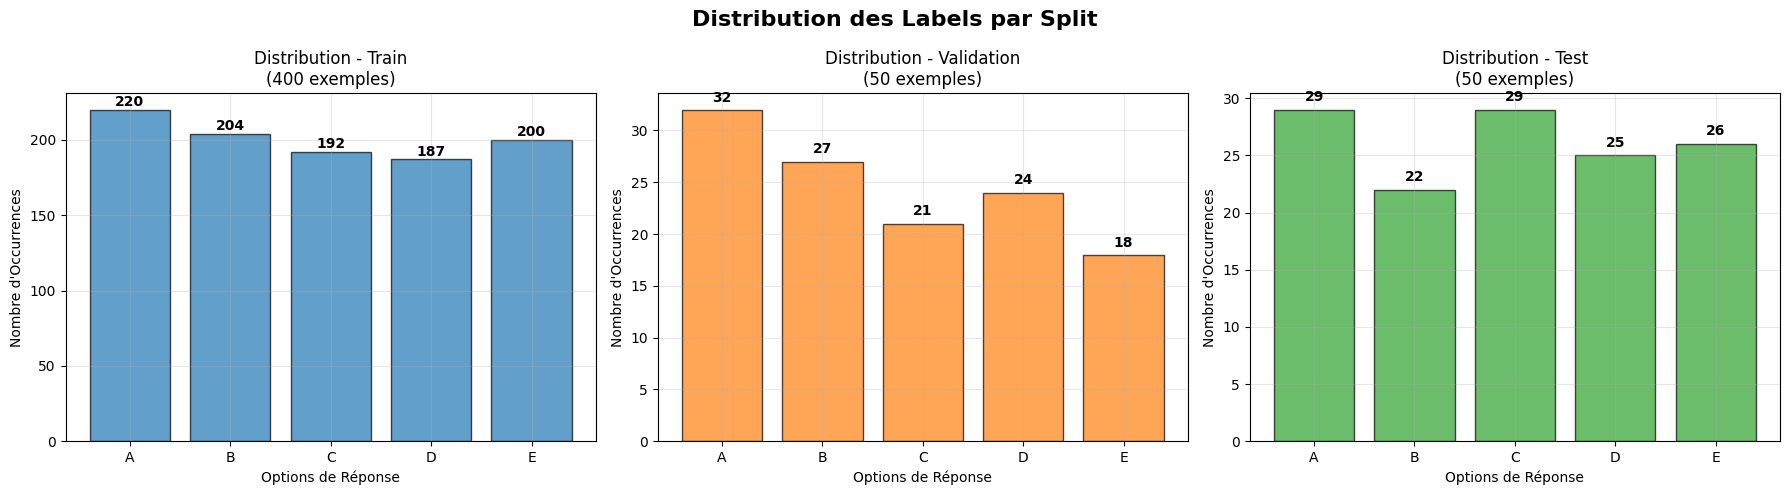

In [36]:
# Division des données en train/validation/test
from sklearn.model_selection import train_test_split

print("=== DIVISION DES DONNÉES ===")

# Définition des noms d'options pour visualisation
option_names = ['A', 'B', 'C', 'D', 'E']

# Stratification basée sur le nombre total de bonnes réponses par question
stratify_labels = [sum(label) for label in labels]

# Division initiale train/temp (80/20)
texts_train, texts_temp, labels_train, labels_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=stratify_labels
)

# Stratification pour la division temp
stratify_temp = [sum(label) for label in labels_temp]

# Division temp en validation/test (50/50 du total)
texts_val, texts_test, labels_val, labels_test = train_test_split(
    texts_temp, labels_temp, test_size=0.5, random_state=123,
)

print(f"Données d'entraînement: {len(texts_train)} exemples")
print(f"Données de validation: {len(texts_val)} exemples")
print(f"Données de test: {len(texts_test)} exemples")

# Vérification de la distribution stratifiée
train_avg_labels = np.array(labels_train).sum(axis=1).mean()
val_avg_labels = np.array(labels_val).sum(axis=1).mean()
test_avg_labels = np.array(labels_test).sum(axis=1).mean()

print(f"\nVérification stratification:")
print(f"Train - moyenne labels/question: {train_avg_labels:.2f}")
print(f"Validation - moyenne labels/question: {val_avg_labels:.2f}")
print(f"Test - moyenne labels/question: {test_avg_labels:.2f}")

# Visualisation de la distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = [
    ('Train', np.array(labels_train)),
    ('Validation', np.array(labels_val)),
    ('Test', np.array(labels_test))
]

for idx, (split_name, split_labels) in enumerate(splits):
    option_counts = split_labels.sum(axis=0)
    axes[idx].bar(option_names, option_counts, alpha=0.7, color=f'C{idx}', edgecolor='black')
    axes[idx].set_title(f'Distribution - {split_name}\n({len(split_labels)} exemples)')
    axes[idx].set_xlabel('Options de Réponse')
    axes[idx].set_ylabel('Nombre d\'Occurrences')
    axes[idx].grid(True, alpha=0.3)

    # Ajout des valeurs sur les barres
    for i, count in enumerate(option_counts):
        axes[idx].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

plt.suptitle('Distribution des Labels par Split', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Entraînement du Modèle

In [37]:

# Choix du modèle pour le français médical
model_name = "camembert-base"  # Alternative: "flaubert/flaubert_base_cased"

# Chargement du tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Tokenizer chargé: {model_name}")
print(f"Taille du vocabulaire: {len(tokenizer)}")

# Configuration pour classification multi-label
from transformers import AutoConfig
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=5,  # 5 options (A, B, C, D, E)
    problem_type="multi_label_classification",
    id2label={0: "A", 1: "B", 2: "C", 3: "D", 4: "E"},
    label2id={"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
)

# Chargement du modèle
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

print(f"Modèle chargé avec {model.num_parameters()} paramètres")
print(f"Architecture: {type(model).__name__}")

# Test de tokenisation sur exemple médical
medical_example = texts[0]
tokens = tokenizer.tokenize(medical_example)
input_ids = tokenizer.encode(medical_example, truncation=True, max_length=512)

print(f"\nTest de tokenisation:")
print(f"Texte original: {len(medical_example)} caractères")
print(f"Tokens générés: {len(tokens)}")
print(f"Input IDs: {len(input_ids)}")
print(f"Premiers tokens: {tokens[:10]}")


=== CONFIGURATION CAMEMBERT POUR MÉDICAL ===
Tokenizer chargé: camembert-base
Taille du vocabulaire: 32005


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

CamembertForSequenceClassification LOAD REPORT from: camembert-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
classifier.out_proj.weight  | MISSING    | 
classifier.dense.bias       | MISSING    | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.bias    | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Modèle chargé avec 110625797 paramètres
Architecture: CamembertForSequenceClassification

Test de tokenisation:
Texte original: 358 caractères
Tokens générés: 101
Input IDs: 103
Premiers tokens: ['▁Parmi', '▁les', '▁affirmation', 's', '▁suivantes', ',', '▁une', '▁seule', '▁est', '▁fausse']


In [38]:
# Création d'un dataset PyTorch pour l'entraînement
import torch
from torch.utils.data import Dataset

class FrenchMedicalDataset(Dataset):
    """
    Dataset personnalisé pour questions médicales françaises multi-label
    """

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenisation
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)  # Labels déjà sous forme de liste [0,1,0,1,1]
        }

# Création des datasets
train_dataset = FrenchMedicalDataset(texts_train, labels_train, tokenizer)
val_dataset = FrenchMedicalDataset(texts_val, labels_val, tokenizer)
test_dataset = FrenchMedicalDataset(texts_test, labels_test, tokenizer)

print(f"Datasets créés:")
print(f"  Train: {len(train_dataset)} exemples")
print(f"  Validation: {len(val_dataset)} exemples")
print(f"  Test: {len(test_dataset)} exemples")

# Test du dataset
sample = train_dataset[0]
print(f"\nÉchantillon du dataset:")
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
print(f"  Labels shape: {sample['labels'].shape}")
print(f"  Labels: {sample['labels'].tolist()}")

# Analyse de la longueur des séquences tokenisées
sequence_lengths = []
for text in texts_train[:100]:  # Échantillon pour analyse
    tokens = tokenizer.encode(text, truncation=False)
    sequence_lengths.append(len(tokens))

print(f"\nAnalyse des longueurs de séquences:")
print(f"  Longueur moyenne: {np.mean(sequence_lengths):.1f} tokens")
print(f"  Longueur médiane: {np.median(sequence_lengths):.1f} tokens")
print(f"  Longueur maximale: {max(sequence_lengths)} tokens")
print(f"  % séquences > 512 tokens: {sum(1 for l in sequence_lengths if l > 512)/len(sequence_lengths)*100:.1f}%")

Datasets créés:
  Train: 400 exemples
  Validation: 50 exemples
  Test: 50 exemples

Échantillon du dataset:
  Input IDs shape: torch.Size([512])
  Attention mask shape: torch.Size([512])
  Labels shape: torch.Size([5])
  Labels: [1.0, 1.0, 1.0, 0.0, 0.0]

Analyse des longueurs de séquences:
  Longueur moyenne: 103.9 tokens
  Longueur médiane: 102.0 tokens
  Longueur maximale: 156 tokens
  % séquences > 512 tokens: 0.0%


In [39]:
# Configuration de l'entraînement optimisée pour Colab
print("=== CONFIGURATION D'ENTRAÎNEMENT ===")

training_args = TrainingArguments(
    output_dir='./medical_french_classifier',
    num_train_epochs=10,  # Réduction pour Colab
    per_device_train_batch_size=8,  # Optimisé pour mémoire GPU
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,
    dataloader_num_workers=0,  # Évite les problèmes de multiprocessing
    fp16=torch.cuda.is_available(),  # Optimisation mémoire GPU
    gradient_checkpointing=True,  # Économie mémoire
    dataloader_pin_memory=False,
    remove_unused_columns=False
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    """
    Calcule les métriques d'évaluation pour classification multi-label
    """
    predictions, labels = eval_pred

    # Conversion des probabilités en prédictions binaires
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = (probs > 0.5).int().numpy()
    y_true = labels.astype(int)

    # Métriques globales
    exact_match = accuracy_score(y_true, y_pred)
    # Métriques par classe (micro et macro)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    return {
        'exact_match': exact_match,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
    }


# Initialisation du trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print(f"Configuration d'entraînement:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size (train): {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Optimisations mémoire: FP16={training_args.fp16}, Gradient checkpointing={training_args.gradient_checkpointing}")

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


=== CONFIGURATION D'ENTRAÎNEMENT ===
Configuration d'entraînement:
  Epochs: 3
  Batch size (train): 8
  Learning rate: 2e-05
  Optimisations mémoire: FP16=True, Gradient checkpointing=True


In [40]:
# Entraînement
print("Début de l'entraînement...")
trainer.train()
print("Entraînement terminé")

Début de l'entraînement...


Step,Training Loss,Validation Loss,Exact Match,F1 Micro,F1 Macro,Precision Micro,Precision Macro,Recall Micro,Recall Macro
100,0.692424,0.686000,0.120000,0.539823,0.389813,0.586538,0.345655,0.500000,0.462963


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Entraînement terminé


## 6. Évaluation et Performance

In [41]:
# Évaluation sur le jeu de test
results = trainer.evaluate()
print("Résultats d'évaluation:")
for metric, value in results.items():
    if metric.startswith('eval_'):
        metric_name = metric.replace('eval_', '')
        print(f"{metric_name}: {value:.3f}")

Résultats d'évaluation:
loss: 0.685
exact_match: 0.000
f1_micro: 0.491
f1_macro: 0.352
precision_micro: 0.539
precision_macro: 0.453
recall_micro: 0.451
recall_macro: 0.436
runtime: 0.440
samples_per_second: 113.718
steps_per_second: 9.097


In [53]:
# Test sur un nouvel exemple
def predire_reponse(question_text, model, tokenizer):
    """
    Prédit quelles options sont correctes pour une question donnée
    """
    inputs = tokenizer(question_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.sigmoid(outputs.logits)  # Sigmoid pour multi-label
        predictions = (probabilities > 0.5).int()  # Seuil à 0.5

    return predictions[0].tolist(), probabilities[0].tolist()

# Test sur l'exemple avec toutes les 5 options
test_question = exemple['question']
test_options = [exemple['answer_a'], exemple['answer_b'], exemple['answer_c'], exemple['answer_d'], exemple['answer_e']]
correct_answers = exemple['correct_answers']

# Créer le texte formaté comme dans l'entraînement
options_text = " [SEP] ".join([f"{chr(65+i)}: {option}" for i, option in enumerate(test_options)])
formatted_text = f"{test_question} [SEP] {options_text}"

print(f"Question: {test_question}")
print("\n - ".join(test_options))
print(f"Réponses attendues: {[chr(65+i) for i in correct_answers]}")

predictions, confidences = predire_reponse(formatted_text, model, tokenizer)
print("\\nPrédictions du modèle:")
for i in range(5):
    option_letter = chr(65+i)
    predicted = "CORRECT" if predictions[i] == 1 else "INCORRECT"
    expected = "✓" if i in correct_answers else "✗"
    confidence = confidences[i]
    print(f"{option_letter}. {predicted} (conf: {confidence:.3f}) [{expected}]")

Question: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha
Sont formées de noyaux d'hélium
 - Sont peu pénétrantes
 - Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l'air
 - Sont arrêtées par une feuille de papier
 - Sont peu ionisantes
Réponses attendues: ['E']
\nPrédictions du modèle:
A. CORRECT (conf: 0.526) [✗]
B. INCORRECT (conf: 0.479) [✗]
C. INCORRECT (conf: 0.487) [✗]
D. INCORRECT (conf: 0.474) [✗]
E. INCORRECT (conf: 0.494) [✓]


=== RÉSULTATS D'ÉVALUATION ===
Exact Match (toutes options correctes): 0.120
F1-Score Micro: 0.504
F1-Score Macro: 0.397
Précision Micro: 0.573
Rappel Micro: 0.450

Métriques par option:
Option A - Précision: 0.580, Rappel: 1.000, F1: 0.734
Option B - Précision: 0.375, Rappel: 0.136, F1: 0.200
Option C - Précision: 1.000, Rappel: 0.069, F1: 0.129
Option D - Précision: 1.000, Rappel: 0.160, F1: 0.276
Option E - Précision: 0.538, Rappel: 0.808, F1: 0.646


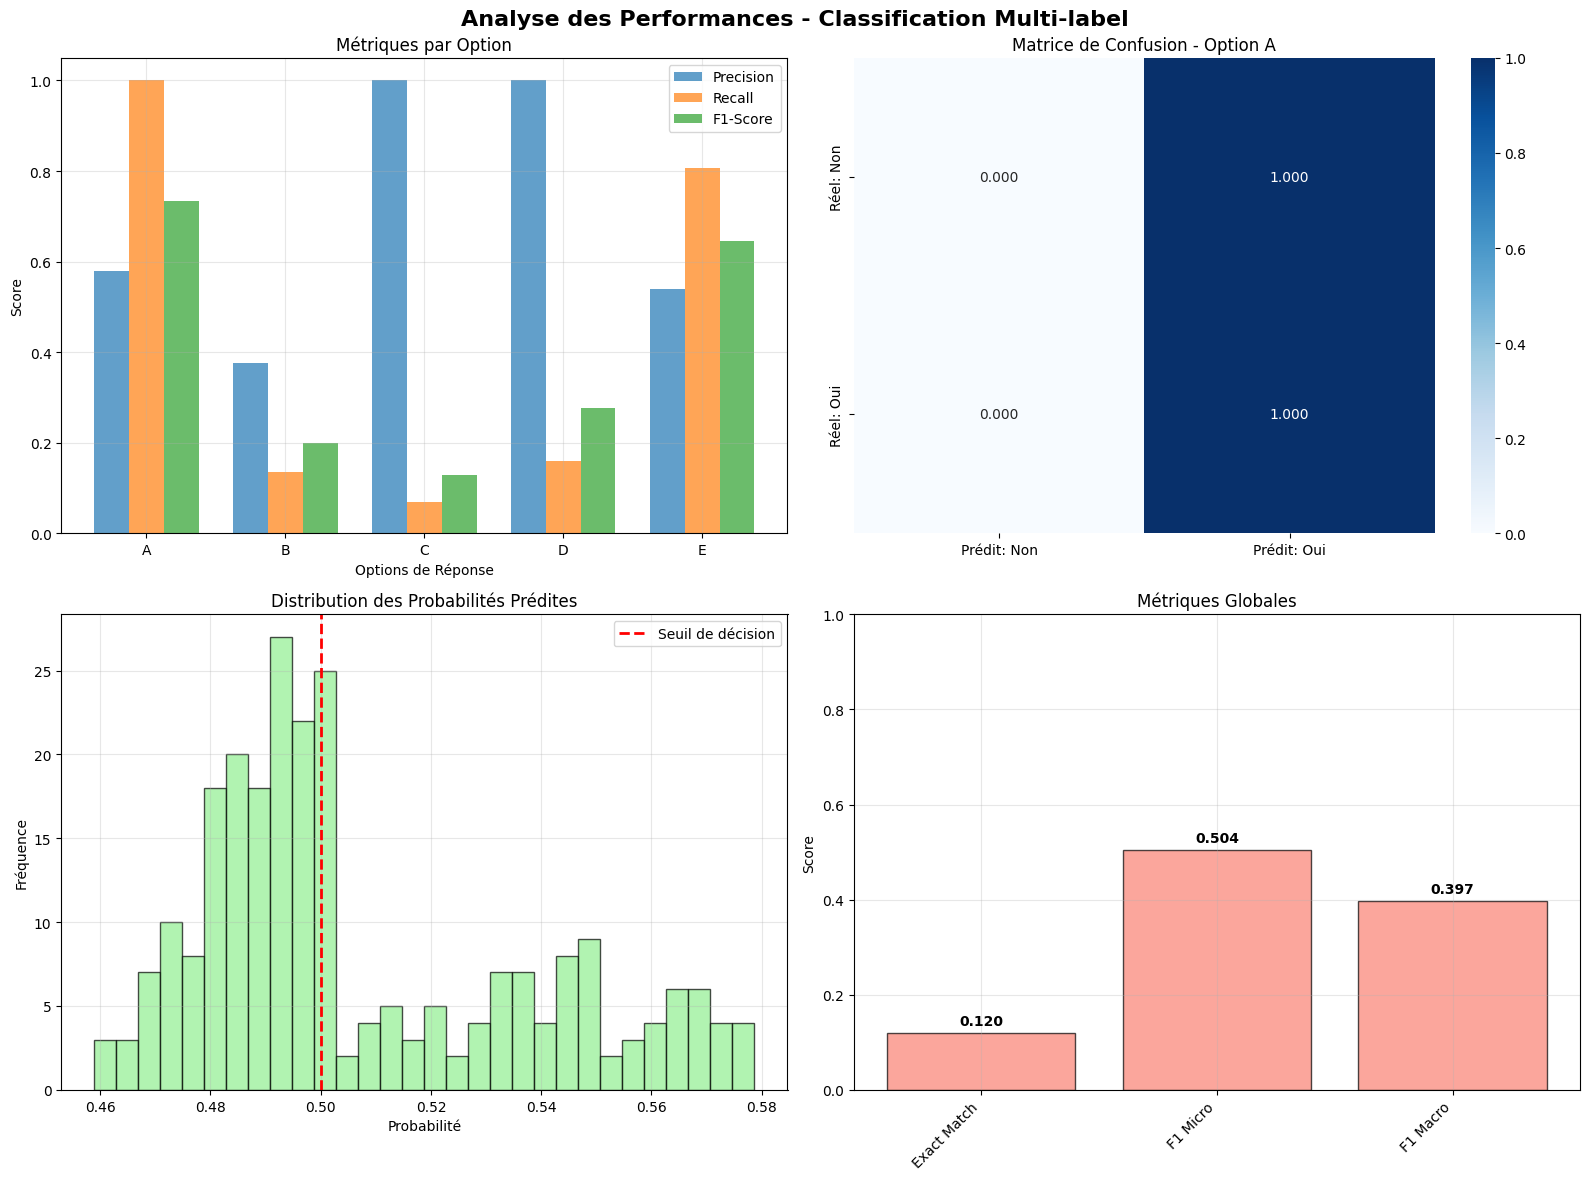

In [55]:
# Évaluation détaillée sur le jeu de test
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Prédictions sur le jeu de test
test_predictions = []
test_probabilities = []
test_true_labels = []

model.eval()
for i in range(len(test_dataset)):
    sample = test_dataset[i]
    inputs = {
        'input_ids': sample['input_ids'].unsqueeze(0).to(model.device),
        'attention_mask': sample['attention_mask'].unsqueeze(0).to(model.device)
    }

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits)
        preds = (probs > 0.5).int()

    test_predictions.append(preds[0].tolist())
    test_probabilities.append(probs[0].tolist())
    test_true_labels.append(sample['labels'].tolist())

test_pred_binary = np.array(test_predictions)
test_probs = np.array(test_probabilities)
test_labels = np.array(test_true_labels)

# Calcul des métriques
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

exact_match = accuracy_score(test_labels, test_pred_binary)
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    test_labels, test_pred_binary, average='micro', zero_division=0
)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    test_labels, test_pred_binary, average='macro', zero_division=0
)

# Métriques par classe
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    test_labels, test_pred_binary, average=None, zero_division=0
)

print("=== RÉSULTATS D'ÉVALUATION ===")
print(f"Exact Match (toutes options correctes): {exact_match:.3f}")
print(f"F1-Score Micro: {f1_micro:.3f}")
print(f"F1-Score Macro: {f1_macro:.3f}")
print(f"Précision Micro: {precision_micro:.3f}")
print(f"Rappel Micro: {recall_micro:.3f}")

print(f"\nMétriques par option:")
for i, option in enumerate(option_names):
    print(f"Option {option} - Précision: {precision_per_class[i]:.3f}, Rappel: {recall_per_class[i]:.3f}, F1: {f1_per_class[i]:.3f}")

# Visualisation des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse des Performances - Classification Multi-label', fontsize=16, fontweight='bold')

# 1. Métriques par classe
x = np.arange(len(option_names))
width = 0.25

axes[0, 0].bar(x - width, precision_per_class, width, label='Precision', alpha=0.7)
axes[0, 0].bar(x, recall_per_class, width, label='Recall', alpha=0.7)
axes[0, 0].bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.7)

axes[0, 0].set_xlabel('Options de Réponse')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Métriques par Option')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(option_names)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Matrice de confusion pour l'option A (exemple)
conf_matrices = multilabel_confusion_matrix(test_labels, test_pred_binary)
cm_normalized = conf_matrices[0] / conf_matrices[0].sum(axis=1, keepdims=True)

sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Prédit: Non', 'Prédit: Oui'],
            yticklabels=['Réel: Non', 'Réel: Oui'],
            ax=axes[0, 1])
axes[0, 1].set_title('Matrice de Confusion - Option A')

# 3. Distribution des scores de confiance
axes[1, 0].hist(test_probs.flatten(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Seuil de décision')
axes[1, 0].set_xlabel('Probabilité')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution des Probabilités Prédites')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Métriques globales
global_metrics = {
    'Exact Match': exact_match,
    'F1 Micro': f1_micro,
    'F1 Macro': f1_macro,
}

metric_names = list(global_metrics.keys())
metric_values = list(global_metrics.values())

bars = axes[1, 1].bar(metric_names, metric_values, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Métriques Globales')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3)
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajout des valeurs sur les barres
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Résumé

### Approches Testées

1. **Prompting Simple**: Instructions directes pour ChatGPT
2. **Few-Shot Learning**: Utilisation d'exemples dans le prompt pour guider le modèle
3. **Classification Automatique**: Entraînement d'un modèle CamemBERT spécialisé

### Applications Pratiques

- **Prompting**: Idéal pour des cas d'usage ponctuels ou des domaines très spécialisés
- **Classification**: Recommandée pour des volumes importants et des besoins de rapidité
- **Hybride**: Combiner prompting pour la validation et classification pour le traitement en masse

Le prochain notebook explorera l'analyse d'images médicales avec TorchXRayVision.